In [ ]:
import torch
print(torch.cuda.is_available())


True


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from imblearn.over_sampling import SMOTE
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define the path to your directory in Google Drive
drive_dir = '/content/drive/My Drive/CICIDS_2017'

# Load data
selected_files = [
    'Monday-WorkingHours.pcap_ISCX.csv',
    'Tuesday-WorkingHours.pcap_ISCX.csv',
    'Friday-WorkingHours-Morning.pcap_ISCX.csv'
]
data_frames = [pd.read_csv(os.path.join(drive_dir, file)) for file in selected_files]
data = pd.concat(data_frames, ignore_index=True)

# Print the total size of the dataset before preprocessing
print(f'Total size of the dataset before preprocessing: {data.shape}')


Total size of the dataset before preprocessing: (1166860, 79)


In [ ]:
# Preprocess data
data = data.replace([np.inf, -np.inf], np.nan).fillna(0)
X = pd.get_dummies(data.drop(' Label', axis=1))
y = LabelEncoder().fit_transform(data[' Label'])

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.7, test_size=0.3, random_state=42)

# Balance the dataset using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)



In [ ]:
# Feature selection
selector = SelectKBest(chi2, k=20)
X_train_selected = selector.fit_transform(X_train_balanced, y_train_balanced)
X_test_selected = selector.transform(X_test)

In [ ]:

# Load the models from Google Drive
lr_model = joblib.load('/content/drive/My Drive/lr_model.pkl')
svm_model = joblib.load('/content/drive/My Drive/svm_model.pkl')

print("Models loaded from Google Drive.")

Models loaded from Google Drive.


In [ ]:
# Train Logistic Regression with further reduced complexity
lr_model = LogisticRegression(C=0.001, penalty='l1', solver='saga', max_iter=200)
lr_model.fit(X_train_selected, y_train_balanced)

# Train SVM with SVC
svm_model = LinearSVC(C=0.001, max_iter=200)
svm_model.fit(X_train_selected, y_train_balanced)

# Save models to Google Drive
joblib.dump(lr_model, '/content/drive/My Drive/lr_model.pkl')
joblib.dump(svm_model, '/content/drive/My Drive/svm_model.pkl')


# Load models
#lr_model = joblib.load('lr_model.pkl')
#svm_model = joblib.load('svm_model.pkl')

['/content/drive/My Drive/svm_model.pkl']

In [ ]:
# Make predictions with both models
lr_predictions = lr_model.predict(X_test_selected)
svm_predictions = svm_model.predict(X_test_selected)

# Print evaluation metrics
print("Logistic Regression Performance:")
print("Accuracy:", accuracy_score(y_test, lr_predictions))
print("Precision:", precision_score(y_test, lr_predictions, average='weighted'))
print("Recall:", recall_score(y_test, lr_predictions, average='weighted'))
print("F1 Score:", f1_score(y_test, lr_predictions, average='weighted'))

print("\nSVM Performance:")
print("Accuracy:", accuracy_score(y_test, svm_predictions))
print("Precision:", precision_score(y_test, svm_predictions, average='weighted'))
print("Recall:", recall_score(y_test, svm_predictions, average='weighted'))
print("F1 Score:", f1_score(y_test, svm_predictions, average='weighted'))

Logistic Regression Performance:
Accuracy: 0.8522559118774603
Precision: 0.9878654258113017
Recall: 0.8522559118774603
F1 Score: 0.9093805781494884

SVM Performance:
Accuracy: 0.8414462746173491
Precision: 0.9878162878972921
Recall: 0.8414462746173491
F1 Score: 0.9031444942852219


In [ ]:
import numpy as np

# Calculate confidence scores for Logistic Regression
lr_confidence_scores = lr_model.predict_proba(X_test_selected)
lr_max_confidence_scores = np.max(lr_confidence_scores, axis=1)

# Calculate pseudo-confidence scores for LinearSVC
svm_decision_scores = svm_model.decision_function(X_test_selected)
svm_pseudo_confidence_scores = 1 / (1 + np.exp(-svm_decision_scores))  # Sigmoid function
svm_max_pseudo_confidence_scores = np.max(svm_pseudo_confidence_scores, axis=1)

# Print the confidence scores
print("Logistic Regression Confidence Scores:")
print(lr_max_confidence_scores)

print("\nLinearSVC Pseudo-Confidence Scores:")
print(svm_max_pseudo_confidence_scores)




Logistic Regression Confidence Scores:
[0.95471478 0.88534791 0.99845154 ... 0.99370709 0.98928756 0.99999987]

LinearSVC Pseudo-Confidence Scores:
[0.70255462 0.71946397 0.78003696 ... 0.74100966 0.72488018 0.97812512]


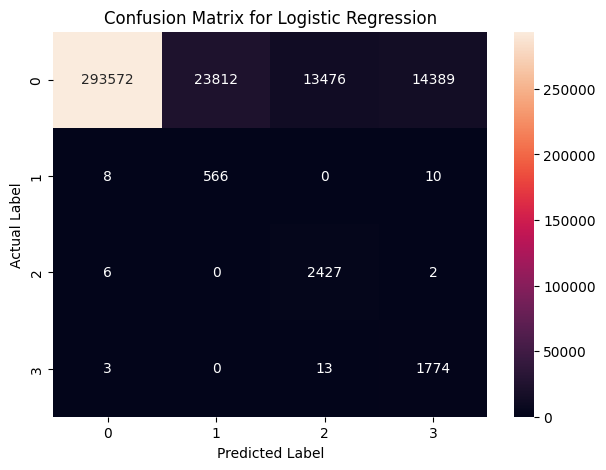

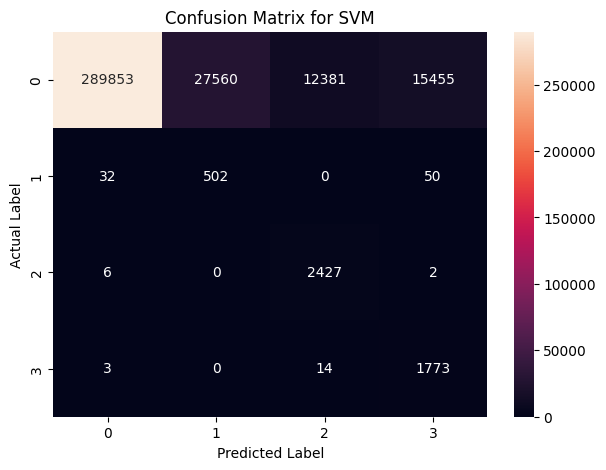

In [ ]:
# Confusion matrix for Logistic Regression
lr_cm = confusion_matrix(y_test, lr_predictions)
plt.figure(figsize=(7, 5))
sns.heatmap(lr_cm, annot=True, fmt='g')
plt.title('Confusion Matrix for Logistic Regression')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Confusion matrix for SVM
svm_cm = confusion_matrix(y_test, svm_predictions)
plt.figure(figsize=(7, 5))
sns.heatmap(svm_cm, annot=True, fmt='g')
plt.title('Confusion Matrix for SVM')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
# Evaluate accuracy per class
label_encoder = LabelEncoder().fit(data[' Label'])
classes = label_encoder.classes_
correct_pred_lr = {classname: 0 for classname in classes}
total_pred_lr = {classname: 0 for classname in classes}

correct_pred_svm = {classname: 0 for classname in classes}
total_pred_svm = {classname: 0 for classname in classes}

# Count correct and total predictions for each class
for label, prediction in zip(y_test, lr_predictions):
    if label == prediction:
        correct_pred_lr[classes[label]] += 1
    total_pred_lr[classes[label]] += 1

for label, prediction in zip(y_test, svm_predictions):
    if label == prediction:
        correct_pred_svm[classes[label]] += 1
    total_pred_svm[classes[label]] += 1

# Print accuracy for each class
print("\nLogistic Regression Model Accuracy per Class:")
for classname, correct_count in correct_pred_lr.items():
    if total_pred_lr[classname] > 0:
        accuracy = 100 * float(correct_count) / total_pred_lr[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    else:
        print(f'Accuracy for class: {classname:5s} is N/A (no samples)')

print("\nSVM Model Accuracy per Class:")
for classname, correct_count in correct_pred_svm.items():
    if total_pred_svm[classname] > 0:
        accuracy = 100 * float(correct_count) / total_pred_svm[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    else:
        print(f'Accuracy for class: {classname:5s} is N/A (no samples)')



Logistic Regression Model Accuracy per Class:
Accuracy for class: BENIGN is 85.0 %
Accuracy for class: Bot   is 96.9 %
Accuracy for class: FTP-Patator is 99.7 %
Accuracy for class: SSH-Patator is 99.1 %

SVM Model Accuracy per Class:
Accuracy for class: BENIGN is 84.0 %
Accuracy for class: Bot   is 86.0 %
Accuracy for class: FTP-Patator is 99.7 %
Accuracy for class: SSH-Patator is 99.1 %


##Attack Code form Scratch

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import concurrent.futures
import joblib
import time


In [ ]:
def calculate_gradient(model, x, y, eps=1e-5):
    grad = np.zeros_like(x)
    for i in range(len(x)):
        x_plus = np.array(x, copy=True)
        x_minus = np.array(x, copy=True)
        x_plus[i] += eps
        x_minus[i] -= eps
        if hasattr(model, 'predict_proba'):
            pred_plus = model.predict_proba(x_plus.reshape(1, -1))[0][y]
            pred_minus = model.predict_proba(x_minus.reshape(1, -1))[0][y]
        else:
            pred_plus = model.decision_function(x_plus.reshape(1, -1))[0][y]
            pred_minus = model.decision_function(x_minus.reshape(1, -1))[0][y]
        grad[i] = (pred_plus - pred_minus) / (2 * eps)
    return grad


In [ ]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)


In [ ]:
def deepfool(model, x, num_classes, max_iter=50, initial_overshoot=0.02, tol=1e-3, early_stopping=True, perturbation_threshold=1e-4):
    if hasattr(model, 'predict_proba'):
        f_image = model.predict_proba(x.reshape(1, -1))[0]
    else:
        f_image = softmax(model.decision_function(x.reshape(1, -1))[0])

    I = f_image.argsort()[::-1]
    label = I[0]

    input_shape = x.shape
    x_adv = x.copy()
    r_tot = np.zeros(input_shape)
    overshoot = initial_overshoot
    prev_confidence = f_image[label]
    perturbation_weights = []

    loop_i = 0
    while label == np.argmax(f_image) and loop_i < max_iter:
        gradients = np.zeros((num_classes, *input_shape))
        for k in range(num_classes):
            gradients[k] = calculate_gradient(model, x_adv, k)

        pert = np.inf
        w = np.zeros(input_shape)
        for k in range(1, num_classes):
            w_k = gradients[k] - gradients[0]
            f_k = f_image[I[k]] - f_image[I[0]]
            norm_w_k = np.linalg.norm(w_k.flatten())
            if norm_w_k != 0:
                pert_k = abs(f_k) / norm_w_k
                if pert_k < pert:
                    pert = pert_k
                    w = w_k

        norm_w = np.linalg.norm(w.flatten())
        if norm_w != 0:
            r_i = (pert + tol) * w / norm_w
            perturbation_weights.append(np.linalg.norm(r_i.flatten()))  # Log the perturbation weight
            r_tot = r_tot + r_i
            x_adv = x_adv + (1 + overshoot) * r_tot
            x_adv = np.clip(x_adv, 0, 1)

            if hasattr(model, 'predict_proba'):
                f_image = model.predict_proba(x_adv.reshape(1, -1))[0]
            else:
                f_image = softmax(model.decision_function(x_adv.reshape(1, -1))[0])
            label = I[0]

            # Adaptive overshoot
            overshoot = initial_overshoot / (1 + loop_i)

            if early_stopping and abs(f_image[label] - prev_confidence) > 0.1:
                break

            prev_confidence = f_image[label]

            if np.linalg.norm(r_i.flatten()) < perturbation_threshold:
                break
        else:
            break
        loop_i += 1

    return x_adv, loop_i, perturbation_weights


In [ ]:
def save_intermediate_results(batch_index, X_adv, perturbation_weights, model_name):
    joblib.dump(X_adv, f'/content/drive/My Drive/{model_name}_X_adv_batch_{batch_index}.pkl')
    joblib.dump(perturbation_weights, f'/content/drive/My Drive/{model_name}_perturbation_weights_batch_{batch_index}.pkl')


In [ ]:
def deepfool_batch(model, X_batch, num_classes, max_iter, batch_index, model_name):
    #print(f"Starting batch {batch_index} with {len(X_batch)} samples")
    start_time = time.time()

    results = []
    for x in X_batch:
        x_adv, _, weights = deepfool(model, x, num_classes=num_classes, max_iter=max_iter)
        results.append((x_adv, weights))

    end_time = time.time()
    #print(f"Completed batch {batch_index} in {end_time - start_time:.2f} seconds")

    # Save intermediate results
    save_intermediate_results(batch_index, [x_adv for x_adv, _ in results], [weights for _, weights in results], model_name)

    return results


In [ ]:
def run_deepfool_threaded(model, X, num_classes, max_iter, batch_size=10, model_name='model'):
    with concurrent.futures.ThreadPoolExecutor(max_workers=mp.cpu_count()) as executor:
        batches = [(model, X[i:i + batch_size], num_classes, max_iter, batch_index, model_name) for batch_index, i in enumerate(range(0, len(X), batch_size))]
        results = list(executor.map(lambda p: deepfool_batch(*p), batches))

    X_adv = []
    perturbation_weights = []
    for batch_result in results:
        for x_adv, weights in batch_result:
            X_adv.append(x_adv)
            perturbation_weights.append(weights)

    return np.array(X_adv), perturbation_weights


In [ ]:
#Example parameters
max_queries = 20  # Reduced from 50
batch_size = 5    # Reduced batch size
sample_size = 200  # Reduced sample size for testing

# Run DeepFool attack on Logistic Regression model in parallel with reduced batch size
X_test_adv_lr, perturbation_weights_lr = run_deepfool_threaded(lr_model, X_test_selected[:sample_size], num_classes=4, max_iter=max_queries, batch_size=batch_size, model_name='lr_model')

# Run DeepFool attack on SVM model in parallel with reduced batch size
X_test_adv_svm, perturbation_weights_svm = run_deepfool_threaded(svm_model, X_test_selected[:sample_size], num_classes=4, max_iter=max_queries, batch_size=batch_size, model_name='svm_model')

# Save results to analyze later
joblib.dump((X_test_adv_lr, perturbation_weights_lr), '/content/drive/My Drive/lr_model_adv_examples.pkl')
joblib.dump((X_test_adv_svm, perturbation_weights_svm), '/content/drive/My Drive/svm_model_adv_examples.pkl')

# Function to load and summarize saved results
def summarize_results(model_name, num_batches):
    X_adv = []
    perturbation_weights = []

    for batch_index in range(num_batches):
        X_adv_batch = joblib.load(f'/content/drive/My Drive/{model_name}_X_adv_batch_{batch_index}.pkl')
        perturbation_weights_batch = joblib.load(f'/content/drive/My Drive/{model_name}_perturbation_weights_batch_{batch_index}.pkl')
        X_adv.extend(X_adv_batch)
        perturbation_weights.extend(perturbation_weights_batch)

    # Summarize results
    total_queries = len(perturbation_weights)
    avg_queries = np.mean([len(weights) for weights in perturbation_weights])
    median_queries = np.median([len(weights) for weights in perturbation_weights])
    max_queries = max([len(weights) for weights in perturbation_weights])
    min_queries = min([len(weights) for weights in perturbation_weights])
    successful_attacks = sum([1 for weights in perturbation_weights if len(weights) < 50])  # assuming 50 is the max queries allowed

    print(f"\n{model_name} Summary:")
    print(f"Total sample size: {total_queries}")
    print(f"Average number of queries: {avg_queries}")
    print(f"Median number of queries: {median_queries}")
    print(f"Max number of queries: {max_queries}")
    print(f"Min number of queries: {min_queries}")
    print(f"Successful attacks: {successful_attacks}/{total_queries}")
    print(f"Average perturbation magnitude: {np.mean([np.mean(weights) for weights in perturbation_weights])}")
    print(f"Median perturbation magnitude: {np.median([np.median(weights) for weights in perturbation_weights])}")
    print(f"Max perturbation magnitude: {np.max([np.max(weights) for weights in perturbation_weights])}")
    print(f"Min perturbation magnitude: {np.min([np.min(weights) for weights in perturbation_weights])}")

# Summarize results for Logistic Regression model
summarize_results('lr_model', len(X_test_adv_lr) // batch_size)

# Summarize results for SVM model
summarize_results('svm_model', len(X_test_adv_svm) // batch_size)



lr_model Summary:
Total sample size: 200
Average number of queries: 2.13
Median number of queries: 1.0
Max number of queries: 12
Min number of queries: 1
Successful attacks: 200/200
Average perturbation magnitude: 2215074409412424.0
Median perturbation magnitude: 1.492715627433573
Max perturbation magnitude: 9.905400386382092e+17
Min perturbation magnitude: 0.001995797860944938

svm_model Summary:
Total sample size: 200
Average number of queries: 4.635
Median number of queries: 3.0
Max number of queries: 20
Min number of queries: 1
Successful attacks: 200/200
Average perturbation magnitude: 0.023521663697941165
Median perturbation magnitude: 0.024375827582082277
Max perturbation magnitude: 0.03473217932804191
Min perturbation magnitude: 0.0010678050640318163


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import joblib

# Function to plot decision boundaries
def plot_decision_boundary(model, X, y, title, ax, pca):
    X_2d = pca.transform(X)

    # Create a mesh to plot the decision boundary
    x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
    y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    X_mesh = pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()])
    Z = model.predict(X_mesh)
    Z = Z.reshape(xx.shape)
    scatter = ax.contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')
    ax.scatter(X_2d[:, 0], X_2d[:, 1], c=y, edgecolor='k', cmap='coolwarm')
    ax.set_title(title)
    return scatter

# Function to visualize feature space
def visualize_feature_space(original, adversarial, original_labels, adversarial_labels, title, cmap='coolwarm'):
    pca = PCA(n_components=2)
    original_2d = pca.fit_transform(original)
    adversarial_2d = pca.transform(adversarial)

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    scatter_original = plt.scatter(original_2d[:, 0], original_2d[:, 1], c=original_labels, cmap=cmap, alpha=0.5, edgecolor='k')
    plt.title(f'{title} - Original Data')
    plt.legend(*scatter_original.legend_elements(), title="Classes")

    plt.subplot(1, 2, 2)
    scatter_adversarial = plt.scatter(adversarial_2d[:, 0], adversarial_2d[:, 1], c=adversarial_labels, cmap=cmap, alpha=0.5, edgecolor='k')
    plt.title(f'{title} - Adversarial Data')
    plt.legend(*scatter_adversarial.legend_elements(), title="Classes")

    plt.tight_layout()
    plt.show()

# Function to plot histograms
def plot_histograms(query_counts_lr, query_counts_svm, perturbation_magnitudes_lr, perturbation_magnitudes_svm):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))

    # Query Counts Histogram
    axes[0, 0].hist(query_counts_lr, bins=20, color='mediumpurple', edgecolor='black')
    axes[0, 0].set_title('Query Counts - Logistic Regression')
    axes[0, 0].set_xlabel('Number of Queries')
    axes[0, 0].set_ylabel('Frequency')

    axes[0, 1].hist(query_counts_svm, bins=20, color='seagreen', edgecolor='black')
    axes[0, 1].set_title('Query Counts - SVM')
    axes[0, 1].set_xlabel('Number of Queries')
    axes[0, 1].set_ylabel('Frequency')

    # Perturbation Magnitudes Histogram
    axes[1, 0].hist(perturbation_magnitudes_lr, bins=20, color='mediumpurple', edgecolor='black')
    axes[1, 0].set_title('Perturbation Magnitudes - Logistic Regression')
    axes[1, 0].set_xlabel('Perturbation Magnitude')
    axes[1, 0].set_ylabel('Frequency')

    axes[1, 1].hist(perturbation_magnitudes_svm, bins=20, color='seagreen', edgecolor='black')
    axes[1, 1].set_title('Perturbation Magnitudes - SVM')
    axes[1, 1].set_xlabel('Perturbation Magnitude')
    axes[1, 1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Function to plot accuracy bar graph
def plot_accuracy_bar_graph(accuracy_before_lr, accuracy_after_lr, accuracy_before_svm, accuracy_after_svm):
    labels = ['Logistic Regression', 'SVM']
    before_attack = [accuracy_before_lr, accuracy_before_svm]
    after_attack = [accuracy_after_lr, accuracy_after_svm]

    x = np.arange(len(labels))  # label locations
    width = 0.1  # bar width

    fig, ax = plt.subplots(figsize=(5, 5))
    bars1 = ax.bar(x - width/2, before_attack, width, label='Before Attack', color='mediumpurple', edgecolor='black')
    bars2 = ax.bar(x + width/2, after_attack, width, label='After Attack', color='seagreen', edgecolor='black')

    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy Before and After Attack')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
# Example parameters for the attack
max_queries = 20  # Adjust as needed
batch_size = 5    # Adjust batch size as needed
sample_size_per_class = 50  # Adjust as needed for a balanced and manageable subset

# Collect indices for each class
class_0_indices = np.where(y_test == 0)[0]
class_1_indices = np.where(y_test == 1)[0]
class_2_indices = np.where(y_test == 2)[0]
class_3_indices = np.where(y_test == 3)[0]

# Perform stratified sampling to get a truly balanced subset
indices_to_sample = np.hstack([
    np.random.choice(class_0_indices, sample_size_per_class, replace=False),
    np.random.choice(class_1_indices, sample_size_per_class, replace=False),
    np.random.choice(class_2_indices, sample_size_per_class, replace=False),
    np.random.choice(class_3_indices, sample_size_per_class, replace=False)
])

X_sample_balanced = X_test_selected[indices_to_sample]
y_sample_balanced = y_test[indices_to_sample]

# Run DeepFool attack on Logistic Regression model for the balanced subset
X_test_adv_lr_balanced, perturbation_weights_lr = run_deepfool_threaded(lr_model, X_sample_balanced, num_classes=4, max_iter=max_queries, batch_size=batch_size, model_name='lr_model')

# Run DeepFool attack on SVM model for the balanced subset
X_test_adv_svm_balanced, perturbation_weights_svm = run_deepfool_threaded(svm_model, X_sample_balanced, num_classes=4, max_iter=max_queries, batch_size=batch_size, model_name='svm_model')

# Predict Adversarial Labels for the Balanced Subset
lr_adv_predictions_balanced = lr_model.predict(X_test_adv_lr_balanced)
svm_adv_predictions_balanced = svm_model.predict(X_test_adv_svm_balanced)

# Calculate accuracies before and after attack
accuracy_before_lr = lr_model.score(X_sample_balanced, y_sample_balanced)
accuracy_after_lr = lr_model.score(X_test_adv_lr_balanced, y_sample_balanced)

accuracy_before_svm = svm_model.score(X_sample_balanced, y_sample_balanced)
accuracy_after_svm = svm_model.score(X_test_adv_svm_balanced, y_sample_balanced)


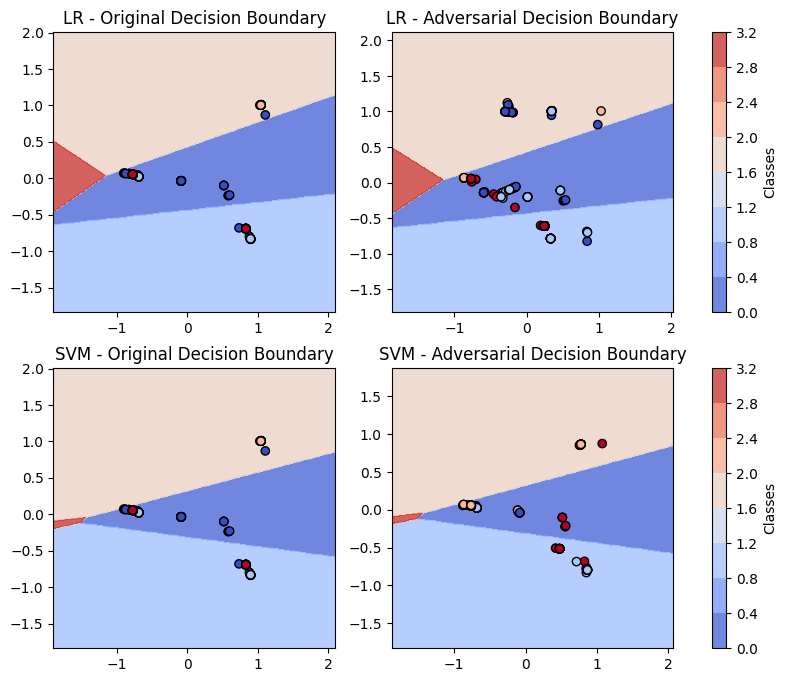

In [ ]:
# Visualize decision boundaries before and after attack
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample_balanced)
X_adv_lr_pca = pca.transform(X_test_adv_lr_balanced)
X_adv_svm_pca = pca.transform(X_test_adv_svm_balanced)

# Plot decision boundary for Logistic Regression before and after attack
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
scatter = plot_decision_boundary(lr_model, X_sample_balanced, y_sample_balanced, 'LR - Original Decision Boundary', ax[0, 0], pca)
plot_decision_boundary(lr_model, X_test_adv_lr_balanced, lr_adv_predictions_balanced, 'LR - Adversarial Decision Boundary', ax[0, 1], pca)
fig.colorbar(scatter, ax=ax[0, :], label='Classes')

# Plot decision boundary for SVM before and after attack
scatter = plot_decision_boundary(svm_model, X_sample_balanced, y_sample_balanced, 'SVM - Original Decision Boundary', ax[1, 0], pca)
plot_decision_boundary(svm_model, X_test_adv_svm_balanced, svm_adv_predictions_balanced, 'SVM - Adversarial Decision Boundary', ax[1, 1], pca)
fig.colorbar(scatter, ax=ax[1, :], label='Classes')
plt.show()


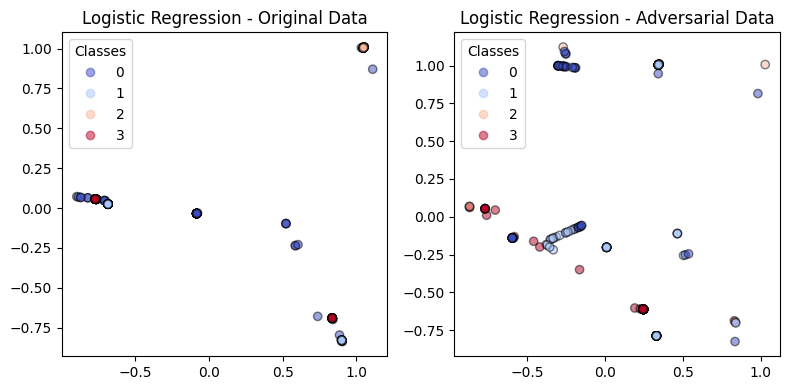

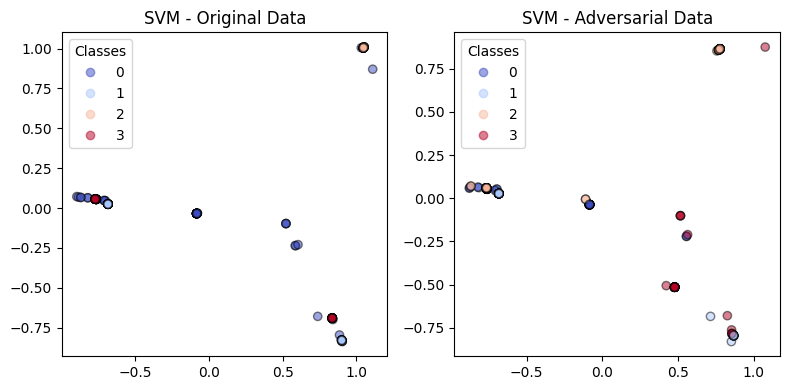

In [ ]:
# Visualize feature space for Logistic Regression with balanced subset
visualize_feature_space(X_sample_balanced, X_test_adv_lr_balanced, y_sample_balanced, lr_adv_predictions_balanced, 'Logistic Regression', cmap='coolwarm')

# Visualize feature space for SVM with balanced subset
visualize_feature_space(X_sample_balanced, X_test_adv_svm_balanced, y_sample_balanced, svm_adv_predictions_balanced, 'SVM', cmap='coolwarm')


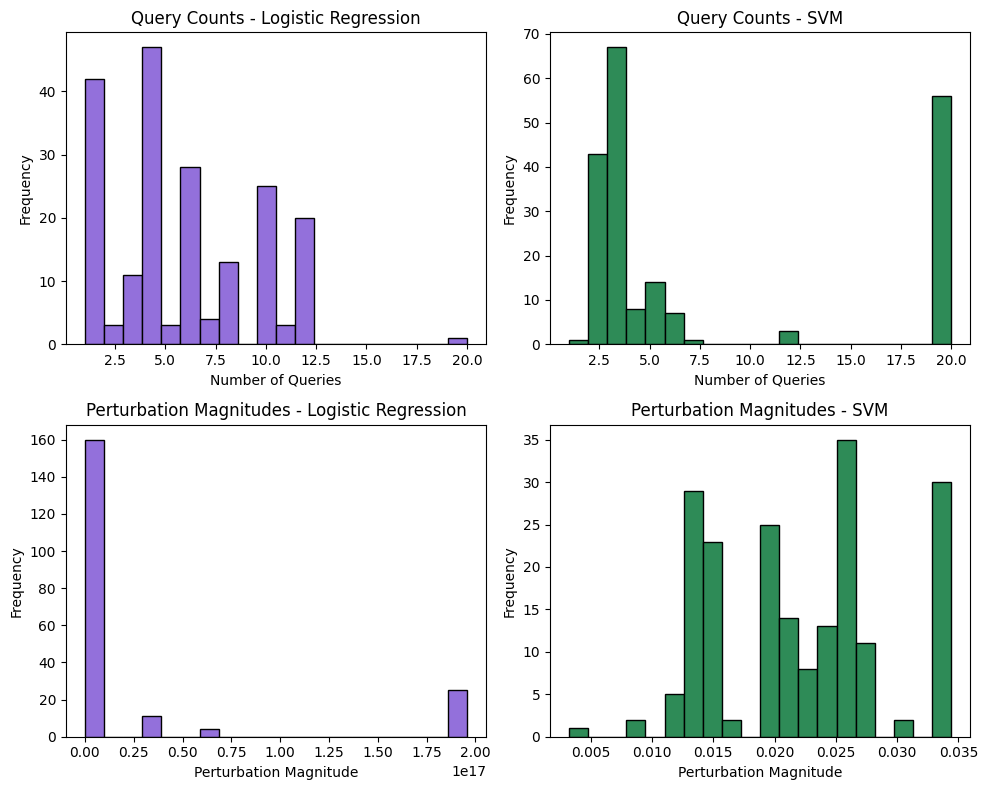

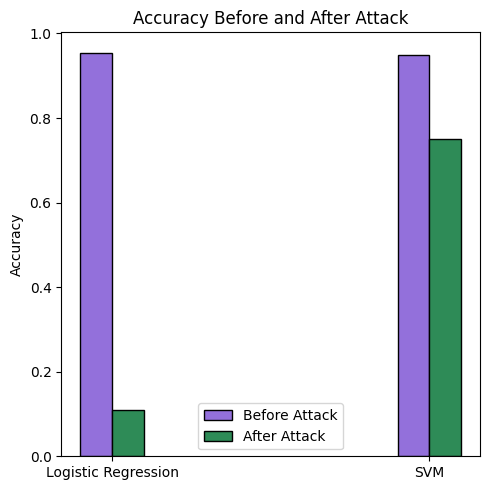

In [ ]:
# Function to plot histograms
def plot_histograms(query_counts_lr, query_counts_svm, perturbation_magnitudes_lr, perturbation_magnitudes_svm):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))

    # Query Counts Histogram
    axes[0, 0].hist(query_counts_lr, bins=20, color='mediumpurple', edgecolor='black')
    axes[0, 0].set_title('Query Counts - Logistic Regression')
    axes[0, 0].set_xlabel('Number of Queries')
    axes[0, 0].set_ylabel('Frequency')

    axes[0, 1].hist(query_counts_svm, bins=20, color='seagreen', edgecolor='black')
    axes[0, 1].set_title('Query Counts - SVM')
    axes[0, 1].set_xlabel('Number of Queries')
    axes[0, 1].set_ylabel('Frequency')

    # Perturbation Magnitudes Histogram
    axes[1, 0].hist([np.mean(weights) for weights in perturbation_magnitudes_lr], bins=20, color='mediumpurple', edgecolor='black')
    axes[1, 0].set_title('Perturbation Magnitudes - Logistic Regression')
    axes[1, 0].set_xlabel('Perturbation Magnitude')
    axes[1, 0].set_ylabel('Frequency')

    axes[1, 1].hist([np.mean(weights) for weights in perturbation_magnitudes_svm], bins=20, color='seagreen', edgecolor='black')
    axes[1, 1].set_title('Perturbation Magnitudes - SVM')
    axes[1, 1].set_xlabel('Perturbation Magnitude')
    axes[1, 1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Plot histograms for query counts and perturbation magnitudes
plot_histograms([len(weights) for weights in perturbation_weights_lr], [len(weights) for weights in perturbation_weights_svm], perturbation_weights_lr, perturbation_weights_svm)

# Plot accuracy bar graph
plot_accuracy_bar_graph(accuracy_before_lr, accuracy_after_lr, accuracy_before_svm, accuracy_after_svm)
